## <center> Практическое домашнее задание 2 </center>

*`credits to ML course by E. Sokolov`*

### Общая информация

Дата выдачи: 23.02.2025

Первый дедлайн: 07:59MSK 22.03.2025

Второй дедлайн: 07:59MSK 24.03.2025

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

**Штраф за каждый день просрочки мягкого дедлайна**: 0.5 баллов. После жесткого дедлайна работы не принимаются.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник.

### Формат сдачи
Задания сдаются через яндекс-форму в чате курса. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [ ]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)

## Введение

*эта часть - введение в задачу, баллов за нее не предусмотрено - она исключительно, чтобы помочь вам :-)*

Решение любой задачи, связанной с машинным обучением, начинается с разведочного анализа данных. Перед тем, как строить модели, надо понять, сколько у нас данных и какая информация есть о каждом объекте, а также:
* выяснить, нет ли пропусков в данных (т.е. отсутствующих значений признаков у некоторых объектов)
* выяснить, нет ли выбросов (т.е. объектов, которые очень сильно отличаются от большинства, имеют неадекватные значения признаков)
* выяснить, нет ли повторов в данных
* выяснить, нет ли нелогичной информации (например, если мы анализируем данные по кредитам, и видим запись, где кредит выдали пятилетнему ребёнку, то это странно)

И это лишь небольшой список проблем, которые можно выявить. Помимо этого с данными нужно в целом познакомиться, чтобы понять, какие признаки там можно сделать, какие из них будут наиболее полезны.

Попробуем провести такой анализ на реальной задаче предсказания продолжительности поездки на такси в Нью-Йорке:

In [ ]:
path = "train.csv"

train = pd.read_csv(path)
train.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

Смысл столбцов:

* id - идентификатор поездки
* vendor_id - код провайдера, от которого пришла информация о поездке
* pickup_datetime - время старта поездки
* dropoff_datetime - время окончания поездки
* passenger_count - число пассажиров (вводится водителем)
* pickup_longitude - долгота точки посадки
* pickup_latitude - широта точки посадки
* dropoff_longitude - долгота точки высадки
* dropoff_latitude - долгота точки высадки
* store_and_fwd_flag - равно Y, если информация о поездке какое-то время хранилась в памяти таксометра из-за отсутствия связи; иначе принимает значение N
* trip_duration - продолжительность поездки в секундах

Посмотрим внимательно на столбцы из нашей таблицы и попробуем проверить, нет ли там противоречий и проблем. Например, в голову приходят следующие вопросы:
* можно ли считать ID уникальным идентификатором поездки, или же есть записи с одинаковыми ID?
* есть ли где-то пропуски?
* действительно ли столбец store_and_fwd_flag принимает только значения Y и N?

In [ ]:
print('Id is unique.') if train.id.nunique() == train.shape[0] else print('oops')
print('We do not need to worry about missing values.') if train.count().min() == train.shape[0] else print('oops')
print('The store_and_fwd_flag has only two values {}.'.format(str(set(train.store_and_fwd_flag.unique()))))

Id is unique.
We do not need to worry about missing values.
The store_and_fwd_flag has only two values {'Y', 'N'}.


In [ ]:
train.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

Видно, что pandas отнёс столбцы с датами к общему типу object. Будет лучше привести их к типу datetime, чтобы использовать удобные функции для манипуляций с датами. Заодно сделаем проверку — действительно ли столбец check_trip_duration показывает продолжительность поездки, или же он входит в противоречие со столбцами pickup_datetime и dropoff_datetime.

In [ ]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = train[np.abs(train['check_trip_duration'].values  - train['trip_duration'].values) > 1]
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

Trip_duration and datetimes are ok.


In [ ]:
train.head()

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude  store_and_fwd_flag  trip_duration pickup_date  \
0         40.765602                   0            455  2016-03-14   
1         40.731152                   0            663  2016-06-12   
2         40.710087                   0           2124  2016-01-19   
3         40.706718                   0            429  2016-04-06   
4         40.782520                   0            435  2016-03-26   

   check_trip_duration  
0                455.0  
1                663.0  
2               2124.0  
3                429.0  
4                435.0

Ещё имеет смысл проверить целевую переменную trip_duration. Нет ли там выбросов? Какими по продолжительности бывают поездки? Выглядит ли распределение этой переменной осмысленно?

Когда в каком-то столбце распределение имеет тяжёлые хвосты или есть выбросы, обычные гистограммы не очень информативны. В этом случае может быть полезно нарисовать распределение в логарифмической шкале.

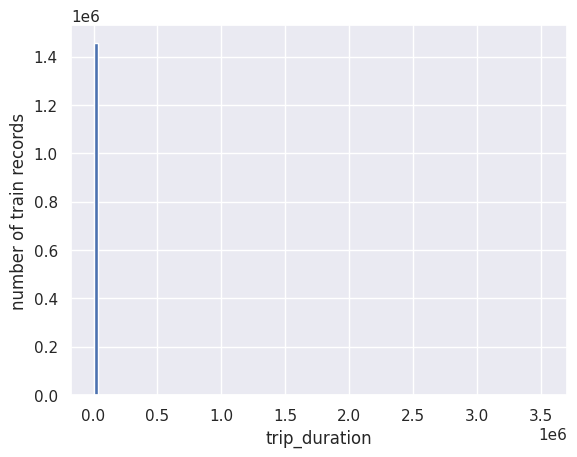

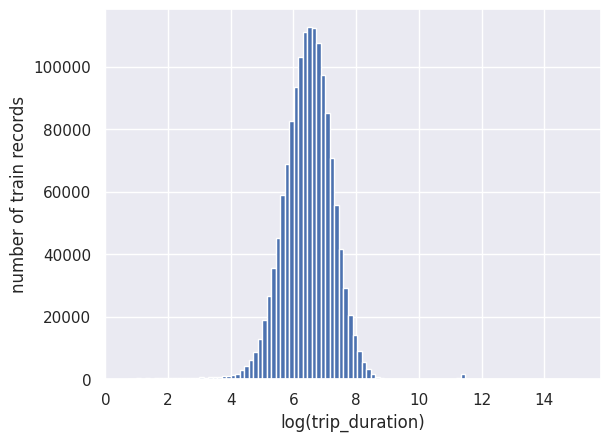

In [ ]:
plt.hist(train['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

train['log_trip_duration'] = np.log1p(train['trip_duration'].values)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

In [ ]:
print("В секундах:", np.exp(5), np.exp(9))
print("В минутах:", np.exp(5) // 60, np.exp(9) // 60)

В секундах: 148.4131591025766 8103.083927575384
В минутах: 2.0 135.0


Кандидатов на выбрасывание не так уж много — например, если взять поездки длиной 10 часа и больше, то их окажется около двух тысяч, и определённо надо выяснять, что это такое.

In [ ]:
train[train.trip_duration >= 10 * 3600]

id  vendor_id     pickup_datetime    dropoff_datetime  \
531      id3307903          2 2016-02-20 04:03:06 2016-02-21 03:33:00   
1134     id1091477          2 2016-05-07 18:36:22 2016-05-08 18:32:11   
1865     id3431345          2 2016-06-07 12:58:48 2016-06-08 12:58:00   
3442     id1487069          2 2016-02-13 00:21:49 2016-02-14 00:19:05   
4172     id3674870          2 2016-03-18 11:54:20 2016-03-19 11:34:17   
...            ...        ...                 ...                 ...   
1455097  id2798196          2 2016-03-20 03:51:36 2016-03-21 00:00:00   
1456458  id2055880          2 2016-02-08 19:11:31 2016-02-09 19:08:44   
1457207  id1910950          2 2016-06-08 16:29:12 2016-06-09 16:11:03   
1457752  id1215198          2 2016-02-02 11:31:10 2016-02-03 11:29:44   
1458076  id2332290          2 2016-04-24 00:58:34 2016-04-25 00:56:16   

         passenger_count  pickup_longitude  pickup_latitude  \
531                    3        -74.008102        40.741489   
1134                   1        -73.990242        40.750919   
1865                   6        -73.954956        40.777649   
3442                   1        -73.968590        40.799217   
4172                   1        -73.989090        40.736992   
...                  ...               ...              ...   
1455097                2        -73.969299        40.757301   
1456458                3        -73.973282        40.760792   
1457207                1        -73.958061        40.800869   
1457752                6        -73.972069        40.794220   
1458076                1        -73.990479        40.760876   

         dropoff_longitude  dropoff_latitude  store_and_fwd_flag  \
531             -74.009956         40.714611                   0   
1134            -73.976280         40.750889                   0   
1865            -73.981033         40.743713                   0   
3442            -73.979584         40.784714                   0   
4172            -73.972336         40.751511                   0   
...                    ...               ...                 ...   
1455097         -73.870277         40.709808                   0   
1456458         -73.988518         40.764210                   0   
1457207         -73.964119         40.805515                   0   
1457752         -73.961014         40.806728                   0   
1458076         -73.983025         40.764557                   0   

         trip_duration pickup_date  check_trip_duration  log_trip_duration  
531              84594  2016-02-20              84594.0          11.345630  
1134             86149  2016-05-07              86149.0          11.363845  
1865             86352  2016-06-07              86352.0          11.366199  
3442             86236  2016-02-13              86236.0          11.364855  
4172             85197  2016-03-18              85197.0          11.352733  
...                ...         ...                  ...                ...  
1455097          72504  2016-03-20              72504.0          11.191411  
1456458          86233  2016-02-08              86233.0          11.364820  
1457207          85311  2016-06-08              85311.0          11.354070  
1457752          86314  2016-02-02              86314.0          11.365759  
1458076          86262  2016-04-24              86262.0          11.365156  

[2012 rows x 14 columns]

Попробуем нарисовать, откуда обычно стартуют поездки.

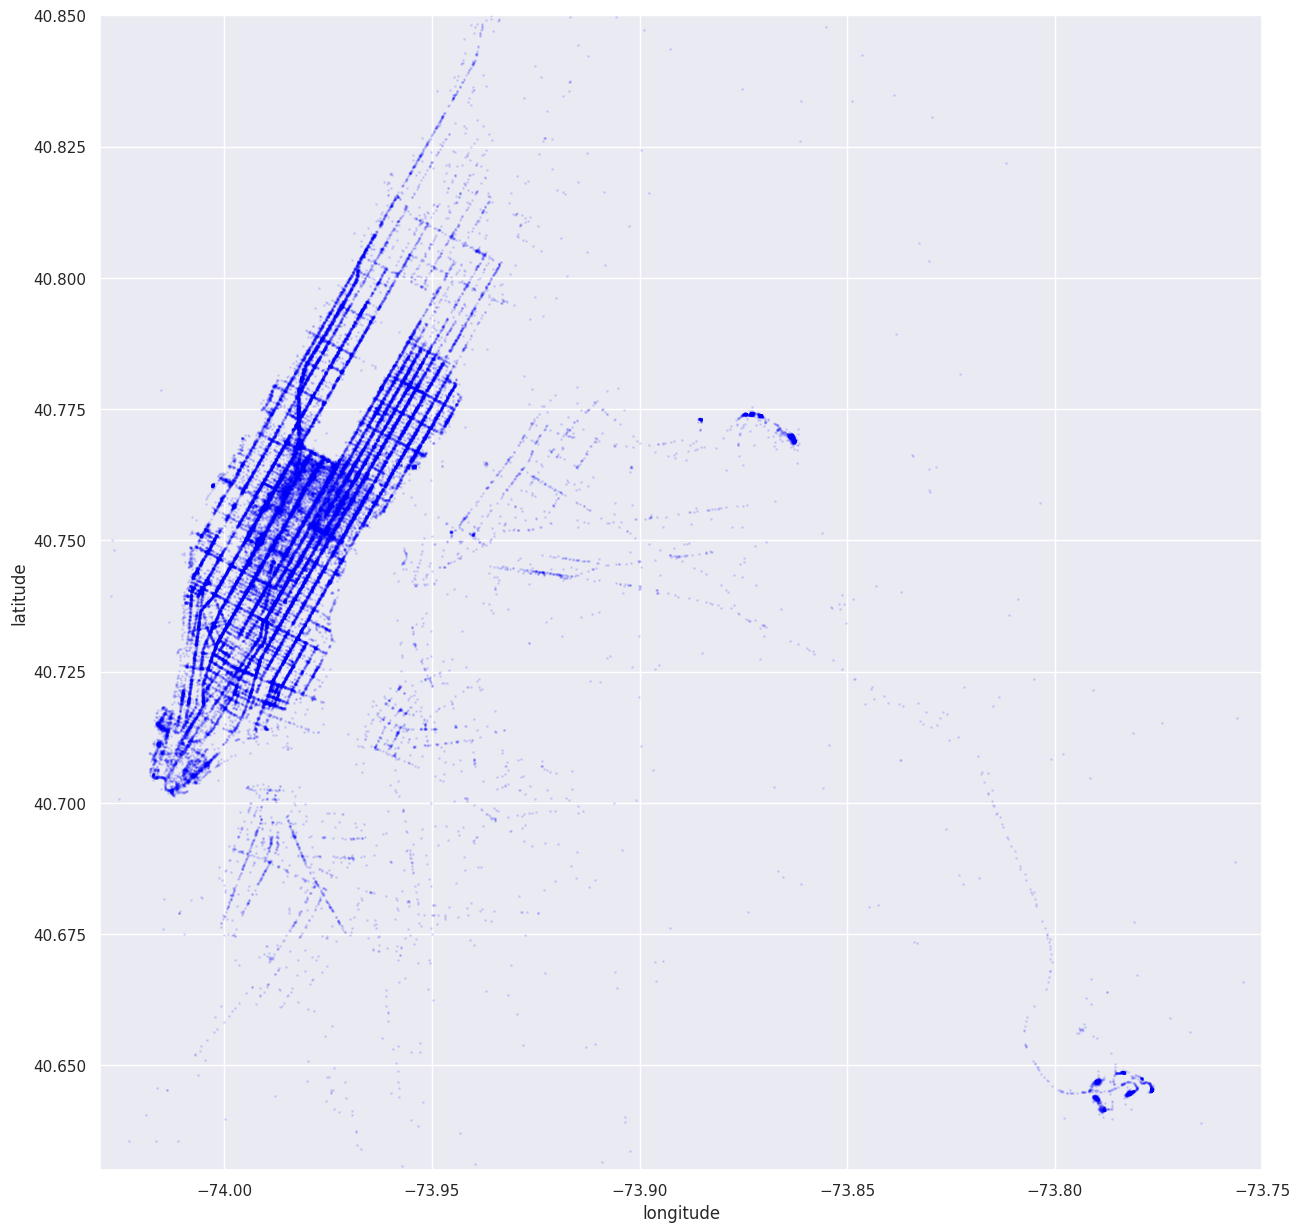

In [ ]:
N = 100000
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.figure(figsize=(15,15))
plt.scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [ ]:
from ipyleaflet import Map, Circle, LayerGroup, basemaps

def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.

    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    center = (data[latitude_column].mean(), data[longitude_column].mean())
    result_map = Map(center=center, zoom=10, basemap=basemaps.Esri.NatGeoWorldMap)

    circles = []
    for _, row in data.iterrows():
        circles.append(Circle(
            location=(row[latitude_column], row[longitude_column]),
            fill_color=color,
            fill_opacity=0.2,
            radius=300,
            stroke=False
        ))
    circles_layer = LayerGroup(layers=circles)
    result_map.add_layer(circles_layer)

    return result_map

show_circles_on_map(train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

Map(center=[np.float64(40.750552330017086), np.float64(-73.97354724121094)], controls=(ZoomControl(options=['p…

Кстати, случайный ли порядок записей в таблице? Это важно понимать, например, для разбиения выборки на обучающую и тестовую части. Если порядок не является случайным, а мы отнесём к обучающей части первую половину таблицы, то есть риск, что данные в обучении и тесте будут иметь разные распределения, а значит, модель сможет хорошо работать только на одной из частей.

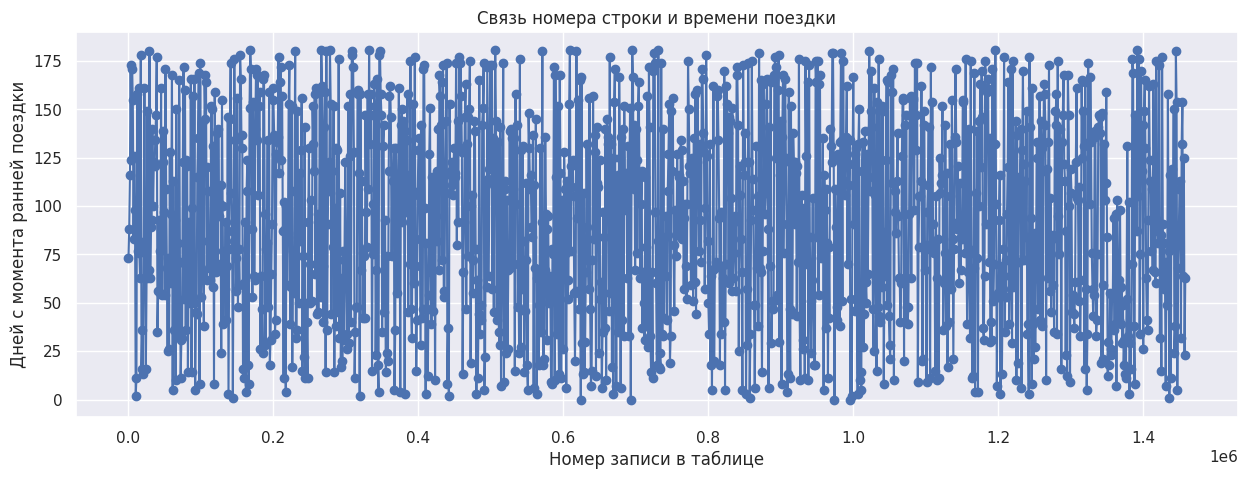

In [ ]:
plt.figure(figsize=(15,5))
days_since_min_ride = (train['pickup_datetime'] - train['pickup_datetime'].min()).apply(lambda x: x.total_seconds() // (60*60*24))
plt.plot(days_since_min_ride[::1000], 'o-')
plt.title('Связь номера строки и времени поездки')
plt.xlabel('Номер записи в таблице')
plt.ylabel('Дней с момента ранней поездки')
plt.show()

Вроде бы всё довольно случайно.

Посчитаем какие-нибудь признаки. Скорее всего продолжительность поездки неплохо зависит от расстояния — посчитаем его. Кстати, важно заметить, что само расстояние не может быть признаком, поскольку в тестовой выборке нет информации о пункте назначения. Но мы пока исследуем данные и, может, увидим в расстояниях что-то интересное.

Можно выбрать научный подход и посчитать честное расстояние на сфере между двумя точками. Это называется haversine distance.

Можно решить, что Земля плоская, и считать стандартные расстояния. В этом случае очень неплохо подойдёт манхэттенское расстояние — оно учитывает, что машины всё-таки не летают.



In [ ]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)

Обсудим немного скорость вычислений в pandas. Есть несколько способов применить функцию к каждой строке в таблице. Если вы до этого изучали преимущественно C/C++, то первое, что должно прийти вам в голову, — написать цикл.

In [ ]:
%%timeit

for i in range(100):
    train[i, 'distance_haversine'] = haversine_array(train['pickup_latitude'].iloc[i],
                                                      train['pickup_longitude'].iloc[i],
                                                      train['dropoff_latitude'].iloc[i],
                                                      train['dropoff_longitude'].iloc[i])

<magic-timeit>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<magic-timeit>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<magic-timeit>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<magic-timeit>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

147 ms ± 3.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Обратите внимание, что мы посчитали расстояния всего лишь для первых 100 записей, и это уже было не очень быстро.

Можно воспользоваться функцией apply.

In [ ]:
%%timeit

train.iloc[:5000, :].apply(lambda x:
                            haversine_array(x['pickup_latitude'],
                                            x['pickup_longitude'],
                                            x['dropoff_latitude'],
                                            x['dropoff_longitude']),
                            axis=1)

154 ms ± 30.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


За то же самое время мы успеваем обработать уже 5000 записей, а не 100.

Но лучший способ — это векторизовать вычисления. Подробнее об этом мы будем говорить на следующих семинарах.

In [ ]:
%%timeit
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values,
                                                     train['pickup_longitude'].values,
                                                     train['dropoff_latitude'].values,
                                                     train['dropoff_longitude'].values)

147 ms ± 36.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Часть 0. Подготовка (1.5 балла)

**Задание 1 (1.5 балла)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

*1.5 балла - за всю эту часть*

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
path = "train.csv"

train = pd.read_csv(path)
train.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train_copy = train.copy()
train = train.drop('dropoff_datetime', axis=1)
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train.head()

id  vendor_id     pickup_datetime  passenger_count  \
0  id2875421          2 2016-03-14 17:24:55                1   
1  id2377394          1 2016-06-12 00:43:35                1   
2  id3858529          2 2016-01-19 11:35:24                1   
3  id3504673          2 2016-04-06 19:32:31                1   
4  id2181028          2 2016-03-26 13:30:55                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   
3        -74.010040        40.719971         -74.012268         40.706718   
4        -73.973053        40.793209         -73.972923         40.782520   

  store_and_fwd_flag  trip_duration  
0                  N            455  
1                  N            663  
2                  N           2124  
3                  N            429  
4                  N            435

In [ ]:
train.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
dtype: object

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

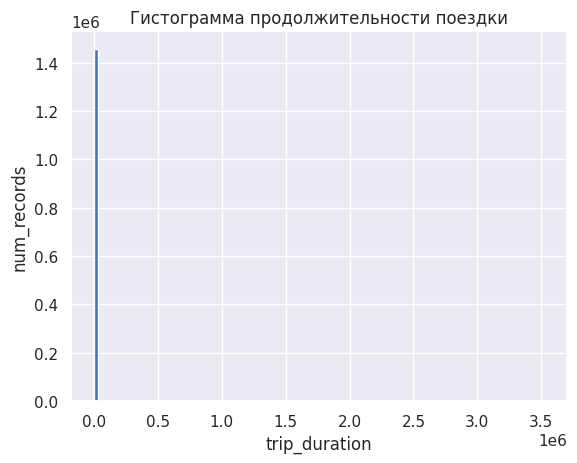

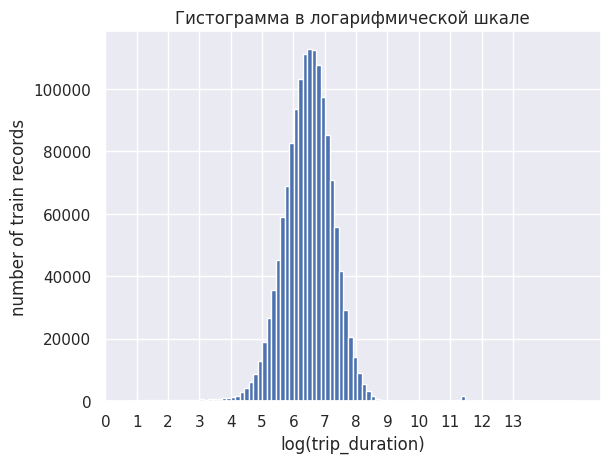

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plt.hist(train.trip_duration, bins=100)
plt.title('Гистограмма продолжительности поездки')
plt.xlabel('trip_duration')
plt.ylabel('num_records')
plt.show()

train['log_trip_duration'] = np.log1p(train['trip_duration'].values)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xticks(np.arange(0, 14, 1))
plt.title('Гистограмма в логарифмической шкале')
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

Визуально распределение целевой переменной - продолжительности поездки - похоже на нормальное. Отсутствуют "тяжелые" хвосты.

In [ ]:
print('Средняя продолжительность поездки:', round(np.exp(train['log_trip_duration'].mean())/60, 3), '±', round(np.exp(train['log_trip_duration'].std())/60, 3), '(мин)')


Средняя продолжительность поездки: 10.726 ± 0.037 (мин)


В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

Мы смогли свести задачу оптимизации RMSLE к эквивалентной задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train_trip_copy = train.copy()
train = train.drop('trip_duration', axis=1)
train.head()

id  vendor_id     pickup_datetime  passenger_count  \
0  id2875421          2 2016-03-14 17:24:55                1   
1  id2377394          1 2016-06-12 00:43:35                1   
2  id3858529          2 2016-01-19 11:35:24                1   
3  id3504673          2 2016-04-06 19:32:31                1   
4  id2181028          2 2016-03-26 13:30:55                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   
3        -74.010040        40.719971         -74.012268         40.706718   
4        -73.973053        40.793209         -73.972923         40.782520   

  store_and_fwd_flag  log_trip_duration  
0                  N           6.122493  
1                  N           6.498282  
2                  N           7.661527  
3                  N           6.063785  
4                  N           6.077642

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [ ]:
def rmsle(log1p_y_true, log1p_y_pred):
    #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    return np.sqrt(np.mean((log1p_y_true - log1p_y_pred)**2))
    raise NotImplementedError

best_const = train.log_trip_duration.mean()
rmsle_best_const =  rmsle(train.log_trip_duration, best_const)
print(round(rmsle_best_const, 5))
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

0.79576


## Часть 1. Изучаем `pickup_datetime` (2.5 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

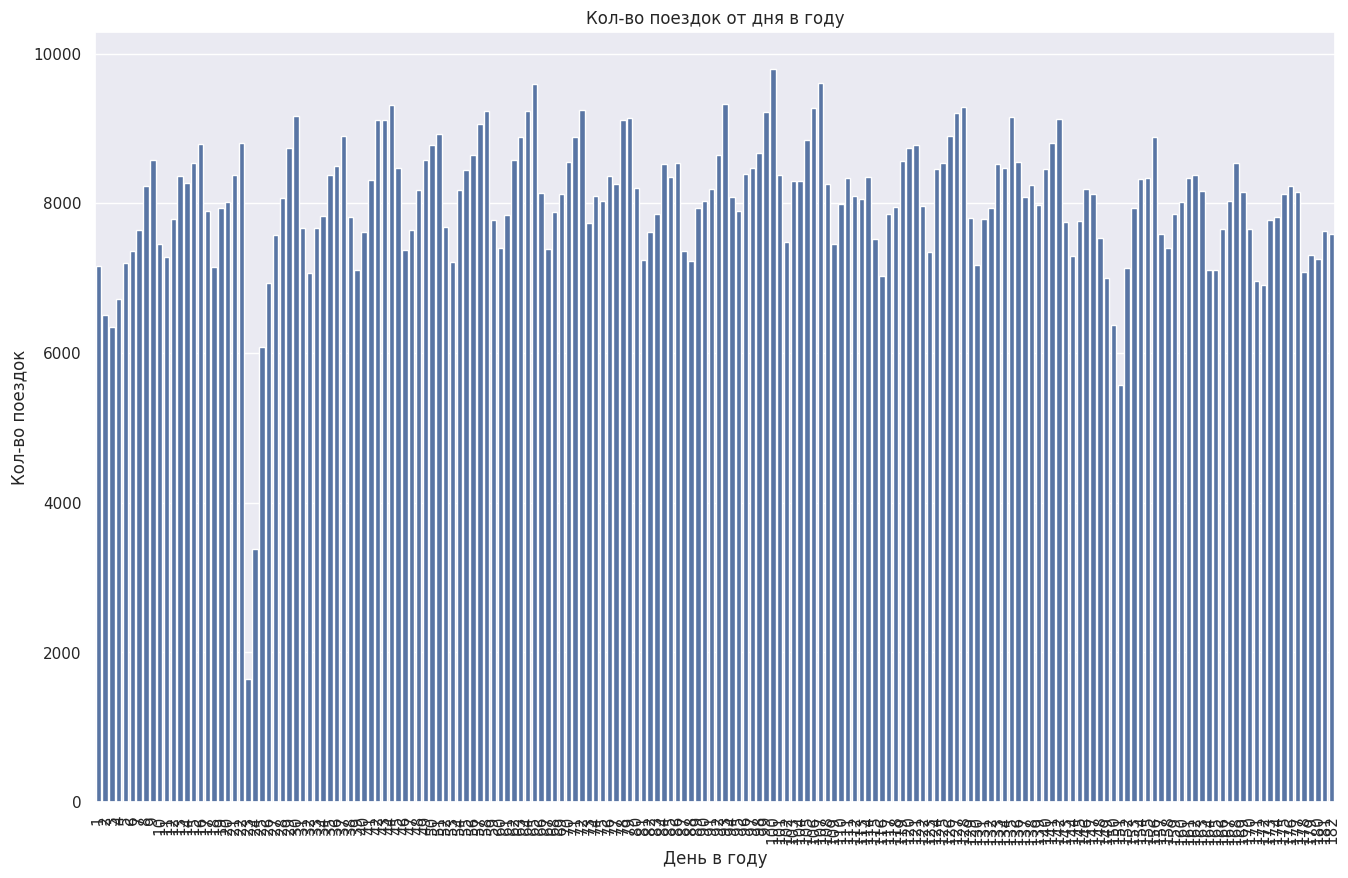

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train['day_of_year'] = train.pickup_datetime.dt.dayofyear
plt.figure(figsize=(16, 10))
sns.countplot(train, x=train['day_of_year'])
plt.title('Кол-во поездок от дня в году')
plt.xlabel('День в году')
plt.ylabel('Кол-во поездок')
plt.xticks(rotation=90)
plt.show()

In [ ]:
mean_ride_amount = train['day_of_year'].value_counts().mean()
std_ride_amount = train['day_of_year'].value_counts().std()

In [ ]:
# Выберем даты в которые кол-во поездок меньше двух СКО от среднего (одного оказалось мало)
anomaly = train['day_of_year'].value_counts()[(train['day_of_year'].value_counts() < (mean_ride_amount-2*std_ride_amount)) == True].sort_index()
anomaly_days = anomaly.index
anomaly

day_of_year
23     1648
24     3383
25     6084
151    5570
Name: count, dtype: int64

С 23 по 25 января 2016 года была мощная снежная буря в Нью-Йорке. 151 день - 31 мая 2016г. - был сильный ураган в Нью-Йорке.

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

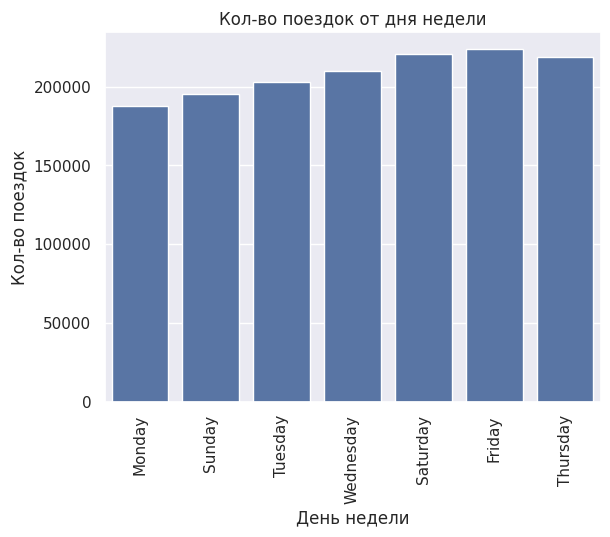

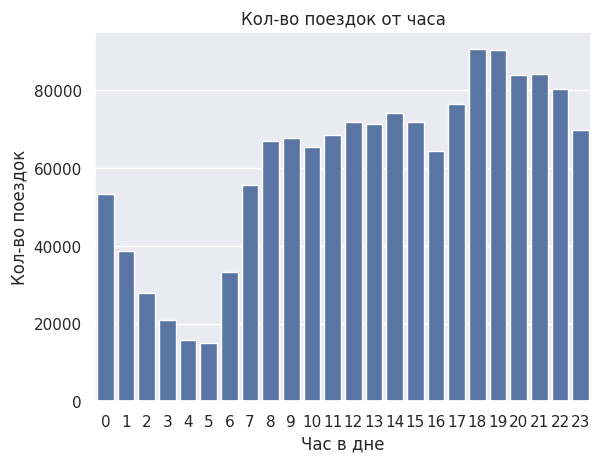

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train['week_day'] = train.pickup_datetime.dt.day_name()
train['day_hour'] = train.pickup_datetime.dt.hour

sns.countplot(train, x=train['week_day'])
plt.title('Кол-во поездок от дня недели')
plt.xlabel('День недели')
plt.ylabel('Кол-во поездок')
plt.xticks(rotation=90)
plt.show()

sns.countplot(train, x=train['day_hour'])
plt.title('Кол-во поездок от часа')
plt.xlabel('Час в дне')
plt.ylabel('Кол-во поездок')
plt.show()

##### По дням недели
Больше всего выделяются пятница и суббота, что логично, так как уже в пятницу вечером многие начинают "отдыхать" и чтобы добраться до места отдыха/дома чаще пользуются такси. Суббота -- аналогичные причины.
##### По часам
Больше всего, конечно, выделяются часы 18-19, а это, как известно, время, в которое люди чаще всего возвращаются с работы. 20-21 также популярное время вызова такси. Возможно, некоторые после работы чуть ждут, когда пройдет час пик. Также это, как мне кажется, популярное время для пятницы и выходных дней, чтобы куда-то поехать.

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

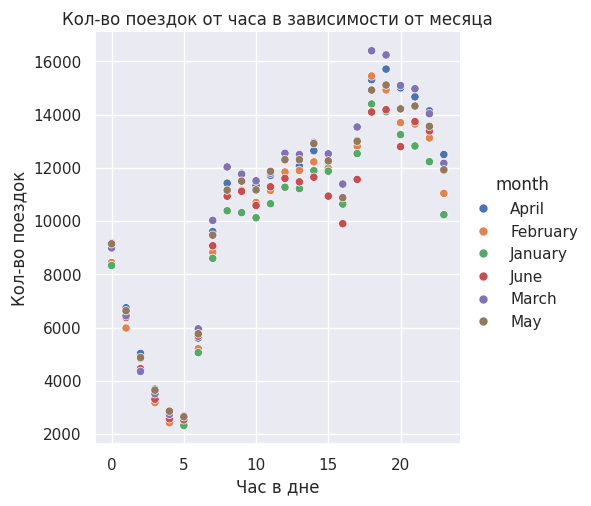

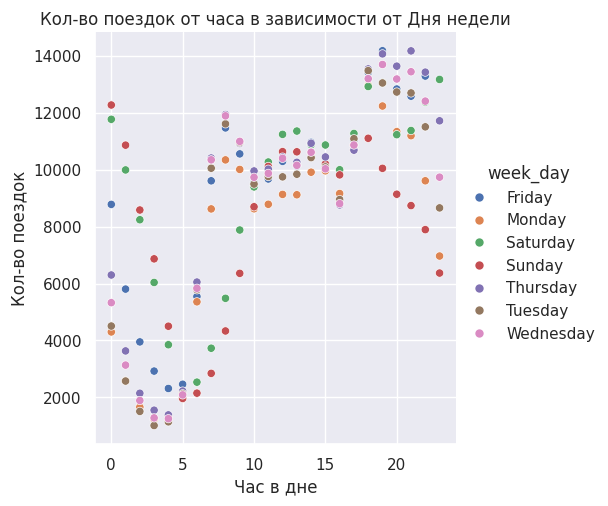

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train['month'] = train.pickup_datetime.dt.month_name()
# делаем группировку по часам и месяцам
month_hour_group = train.groupby(['day_hour', 'month']).size().reset_index(name='count')

sns.relplot(month_hour_group, x='day_hour', y='count', hue='month')
plt.title('Кол-во поездок от часа в зависимости от месяца')
plt.xlabel('Час в дне')
plt.ylabel('Кол-во поездок')
plt.show()

# делаем группировку по часам и дням недели
week_hour_group = train.groupby(['day_hour', 'week_day']).size().reset_index(name='count')

sns.relplot(week_hour_group, x='day_hour', y='count', hue='week_day')
plt.title('Кол-во поездок от часа в зависимости от Дня недели')
plt.xlabel('Час в дне')
plt.ylabel('Кол-во поездок')
plt.show()

##### Часы/месяц
Видно, что в весенние месяцы спрос на такси чуть больше. Как будто, потому что в январе-феврале вообще лениво и хочется поменьше куда-либо выходить и веселиться. Долгожданная весна и потепление пробуждают в людях желание выходить почаще. Но в июне, можно заметить, почти наименьшее кол-во поездок особенно в вечернее время. Ну а действительно, зачем такси, если тепло и можно прогуляться.
##### По дням недеели и часам
Воскресенье и суббота - явные лидеры по вызову такси в ранние часы (видимо, люди возвращаются домой после веселья). Начиная с 6 часов утра, лидируют будние дни, что логично, ведь люди начинают выезжать на работу. Меньше всего днем куда-то вызывают такси по понедельникам. Ну, первый рабочий день на неделе, надо и поработать. Меньше всего поездок в вечернее время наблюдается в вскр: наотдыхались, дома откисаем + готовимся к пн.

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Задание 4 (1 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.model_selection import train_test_split

In [ ]:
features = train.drop(columns='log_trip_duration')
target = train[train.columns[-5]]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=0)

In [ ]:
train_split = pd.concat([X_train, y_train], axis=1)
week_mean = train_split.groupby('week_day').log_trip_duration.mean()
hour_mean = train_split.groupby('day_hour').log_trip_duration.mean()
day_year_mean = train_split.groupby('day_of_year').log_trip_duration.mean()

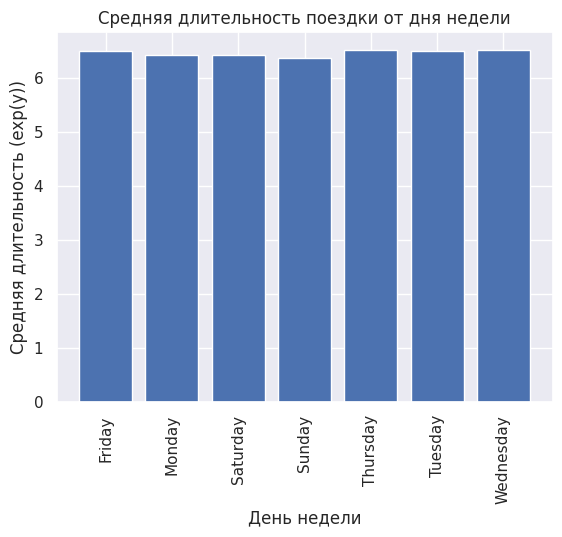

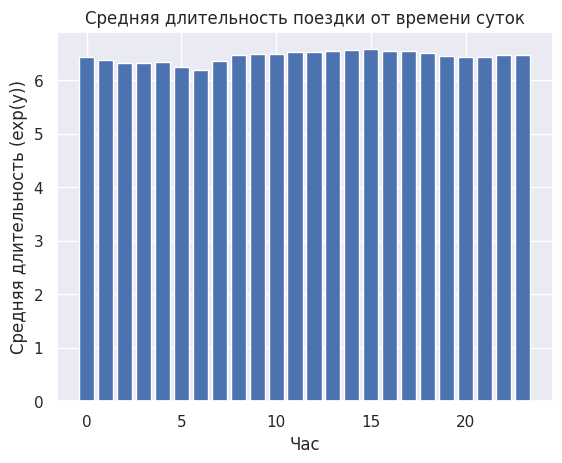

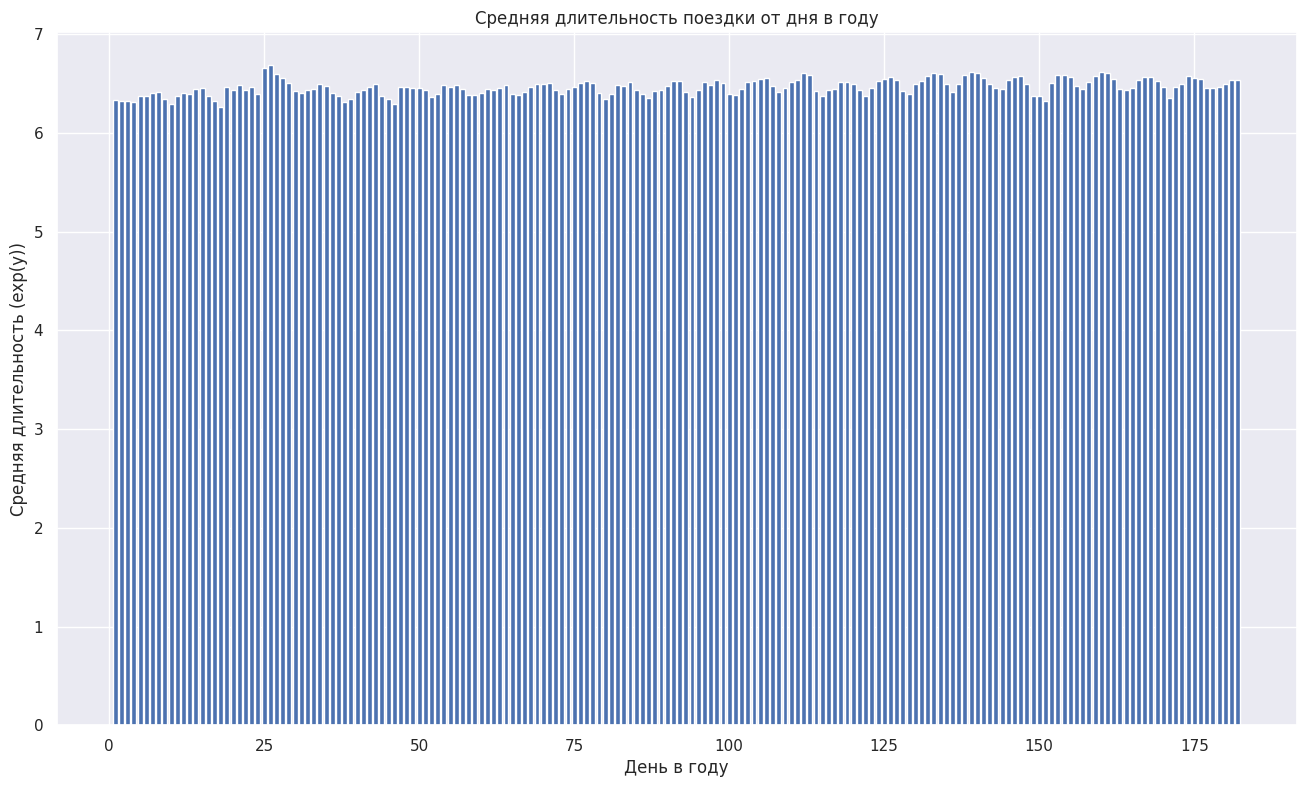

In [ ]:
plt.bar(week_mean.index, height=week_mean)
plt.title('Средняя длительность поездки от дня недели')
plt.xlabel('День недели')
plt.ylabel('Средняя длительность (exp(y))')
plt.xticks(rotation=90)
plt.show()

plt.bar(hour_mean.index, height=hour_mean)
plt.title('Средняя длительность поездки от времени суток')
plt.xlabel('Час')
plt.ylabel('Средняя длительность (exp(y))')
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(day_year_mean.index, height=day_year_mean)
plt.title('Средняя длительность поездки от дня в году')
plt.xlabel('День в году')
plt.ylabel('Средняя длительность (exp(y))')
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Нет, не похожи
##### День недели
В среднем кол-во времени затрачиваемое на поездки в каждый день недели похоже. Возможно, что будни компенсируют увеличивающееся кол-во поездок в выходные за счет продолжительности, так как в будние люди чаще стоят в пробках в часы пик.
##### Время суток
У времени суток в принципе прослеживается тренд, который наблюдался раннее (что с 0 до 6 утра падает, в 7 возрастает). Но удивительно, что днем нет просадок на графике. Возможно, днем у людей происходят наиболее продолжительные поездки, как раз чтоб не попасть в вечерние пробки. Или кол-во поездок в выходные днем невелирует этот эффект.
##### День в году
В графиках с днями в году не наблюдается аномальный эффект, что был ранее на графиках. Это может быть связано с тем, что несмотря на то, что кол-во самих поездок уменьшилось, в каждый из "аномальных" дней водителям приходилось быть более осторожными и замедлять скорость движения из-за условий непогоды (в пургу мы все едем медленнее и из-за плохой погоды, и из-за того, что в таких условиях уже скопилось достаточное кол-во аварий). Из-за этого среднее в аномальные дни не выделяется на графиках.</br>
Также наблюдается паттерн волны на графике зависимости log_trip_duration от номера дня в году. Продолжительность волны длится около 7 дней, что может указывать на недельные волны. Видимо, всю неделю тенденция идет на возрастание продолжительности поездок, в пятницу-субботу оно выходит на максимальное значение, в воскресение начинается "спуск".

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# Первые три и последний раннее добавила
# Добавление аномалий
train['anomaly'] = np.where(np.in1d(train['day_of_year'], anomaly_days), 1, 0)

<ipython-input-38-177b6a5388cd>:4: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  train['anomaly'] = np.where(np.in1d(train['day_of_year'], anomaly_days), 1, 0)


Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

* День недели - категориальный (их нельзя сравнить между друг другом, как числа)
* Час - категориальный (потому что мы не можем производить над ними обычные числовые операции типа деления. Это просто не будет иметь смысла).</br>
* Месяц - категориальный, как и день недели
* Номер дня в году - категориальный, потому что само число не несет в себе информации (да, мы можем сравнить, что первый день меньше второго,
но по сути это не несет смысла).
* Аномалия - категориальный признак, который как будто декодирован уже в бинарный вид и к нему нет необходимости применять OHE.


**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
tab_ohe = train[train.columns[-6:]]
tab_ohe = tab_ohe.drop(columns=['log_trip_duration'])
tab_ohe.head()

day_of_year   week_day  day_hour    month  anomaly
0           74     Monday        17    March        0
1          164     Sunday         0     June        0
2           19    Tuesday        11  January        0
3           97  Wednesday        19    April        0
4           86   Saturday        13    March        0

In [ ]:
tab_ohe = pd.get_dummies(tab_ohe, columns=['week_day', 'day_hour', 'month', 'day_of_year'], drop_first=True)

In [ ]:
X_train_ohe, X_test_ohe, y_train, y_test  = train_test_split(tab_ohe, target, \
                                                     test_size=0.3,\
                                                     shuffle=True,
                                                     random_state=0)

In [ ]:
clf = Ridge()
clf.fit(X_train_ohe, y_train)

y_pred = clf.predict(X_test_ohe)

In [ ]:
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'R²: {r2_score(y_test, y_pred)}') # коэффициент детерминации, нам его давали на парах по мат.стату

MSE: 0.6171518183474178
R²: 0.019846668551199875


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [ ]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.

    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [ ]:
show_circles_on_map(train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [ ]:
show_circles_on_map(train.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

Два аэропорта (Джона Кеннеди и второй аэропорт Ла-Гуардия). Там достаточное кол-во посадок/высокдок для статистики и мы точно можем понять, куда направлялись пассаажиры (это не перепутать). Еще одно место сложно выбрать, так как в городе большое кол-во скоплений точек, но не про все мы так уверены, куда они стремились.

**Задание 6 (1 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine` из одноименной библтотеки. Также можно воспользоваться кодом из введения. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

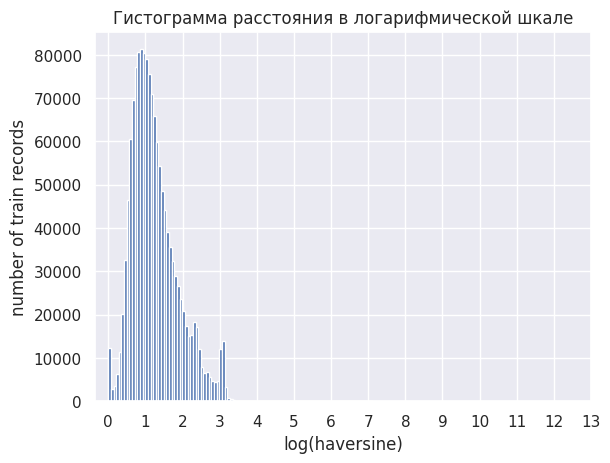

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train['log_haversine'] = np.log1p(train['distance_haversine'].values)
plt.hist(train['log_haversine'].values, bins=100)
plt.xticks(np.arange(0, 14, 1))
plt.title('Гистограмма расстояния в логарифмической шкале')
plt.xlabel('log(haversine)')
plt.ylabel('number of train records')
plt.show()

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [ ]:
your_df = train
assert your_df['log_haversine'].corr(your_df['log_trip_duration']) > your_df['distance_haversine'].corr(your_df['log_trip_duration'])

**Задание 7 (1 балл)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

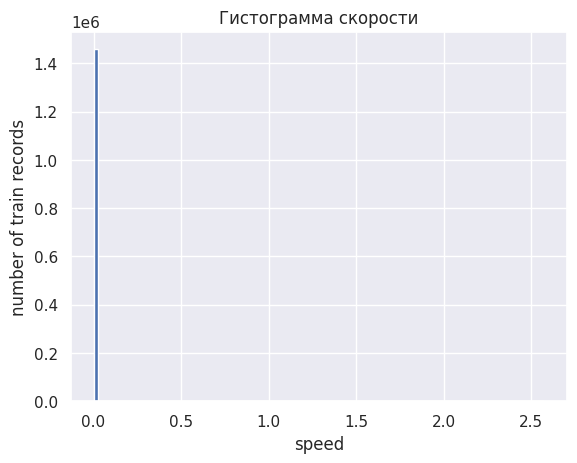

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train['speed'] = train.distance_haversine / train_copy.trip_duration
plt.hist(train['speed'].values, bins=100)
plt.title('Гистограмма скорости')
plt.xlabel('speed')
plt.ylabel('number of train records')
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

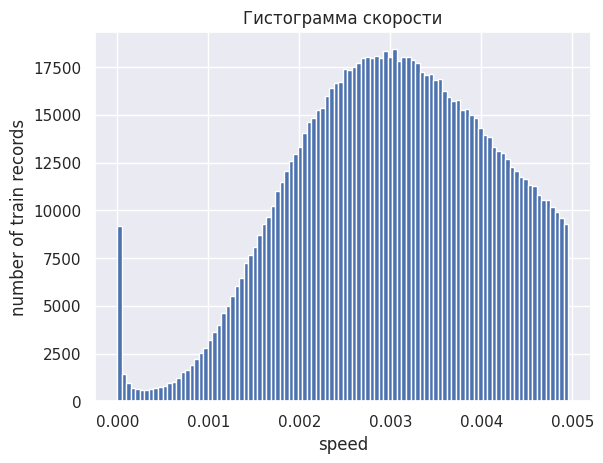

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
quant_75 = train['speed'].quantile(0.75)
quant_speed = train['speed'][train['speed'] < quant_75]
plt.hist(quant_speed.values, bins=100)
plt.title('Гистограмма скорости')
plt.xlabel('speed')
plt.ylabel('number of train records')
plt.show()


Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

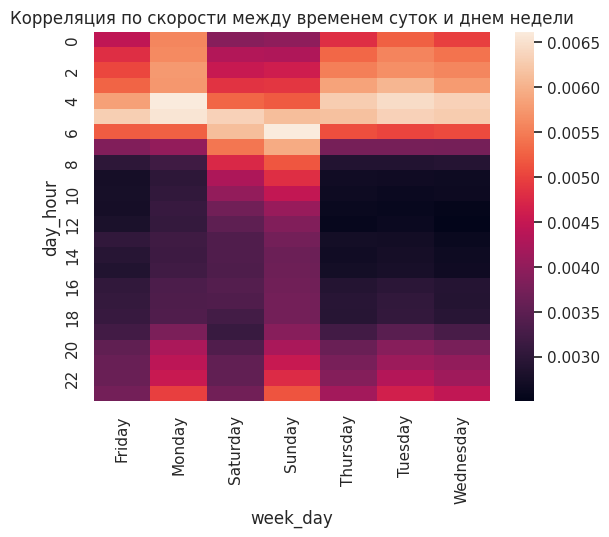

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
week_hour_group = train.groupby(['week_day', 'day_hour']).speed.median().reset_index()
week_hour = pd.pivot(week_hour_group, index="day_hour", columns="week_day", values="speed") # взято из документации к heatmap
# где примеры https://seaborn.pydata.org/generated/seaborn.heatmap.html

sns.heatmap(data=week_hour)
plt.title('Корреляция по скорости между временем суток и днем недели')
plt.show()

In [ ]:
train = train.drop(columns='speed')

Скорость минимальна в будние дни с 7 до 19, в выходные дни в это же время скорость чуть выше, но все равно не сильно. Возрастание скорости начинается с 20-21 часов и максимальна к 4-5 часам утра (также в 6-7 утра в выходные скорость убывает медленнее, чем в будние). Логично, так как ночью дороги свободнее и машин меньше, а значит можно разогнаться).

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟПотому что это косвенная метрика и мы ее не знаем точно (да, у нас есть расстояние, рассчитанное из координат, но оно отражает прямой и быстрый путь, а не реальные объезды и маневры), а также факторы, которые на нее повлияли. Из-за такого расчета и получилось, что в некоторых случаях скорость должна быть очень большой, чтобы куда-то доехать.

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [ ]:
weekend = ['Saturday', 'Sunday']
all_days = train['week_day'].unique()
# Делаем массив будних дней
work_days = [day for day in all_days if day not in weekend]
work_days

['Monday', 'Tuesday', 'Wednesday', 'Friday', 'Thursday']

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# Добавление пробок. Будем считать, что время пробок с 8 до 19 в будни, исходя из тепловой карты выше.
traffic_jam_hours = np.arange(8, 20, 1)
train['traffic_jam'] = np.where(
    (np.in1d(train['day_hour'], traffic_jam_hours))
    & (np.in1d(train['week_day'], work_days)),
    1, 0)
train.tail()

<ipython-input-56-e16fbdb48f55>:5: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  (np.in1d(train['day_hour'], traffic_jam_hours))
<ipython-input-56-e16fbdb48f55>:6: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  & (np.in1d(train['week_day'], work_days)),


id  vendor_id     pickup_datetime  passenger_count  \
1458639  id2376096          2 2016-04-08 13:31:04                4   
1458640  id1049543          1 2016-01-10 07:35:15                1   
1458641  id2304944          2 2016-04-22 06:57:41                1   
1458642  id2714485          1 2016-01-05 15:56:26                1   
1458643  id1209952          1 2016-04-05 14:44:25                1   

         pickup_longitude  pickup_latitude  dropoff_longitude  \
1458639        -73.982201        40.745522         -73.994911   
1458640        -74.000946        40.747379         -73.970184   
1458641        -73.959129        40.768799         -74.004433   
1458642        -73.982079        40.749062         -73.974632   
1458643        -73.979538        40.781750         -73.972809   

         dropoff_latitude store_and_fwd_flag  log_trip_duration  day_of_year  \
1458639         40.740170                  N           6.658011           99   
1458640         40.796547                  N           6.486161           10   
1458641         40.707371                  N           6.639876          113   
1458642         40.757107                  N           5.924256            5   
1458643         40.790585                  N           5.293305           96   

        week_day  day_hour    month  anomaly  distance_haversine  \
1458639   Friday        13    April        0            1.225080   
1458640   Sunday         7  January        0            6.049836   
1458641   Friday         6    April        0            7.824606   
1458642  Tuesday        15  January        0            1.092564   
1458643  Tuesday        14    April        0            1.134042   

         log_haversine  traffic_jam  
1458639       0.799793            1  
1458640       1.953004            0  
1458641       2.177544            0  
1458642       0.738390            1  
1458643       0.758018            1

**Задание 8 (0.5 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

*можно использовать данные координат из интернета или воспользоваться `from geopy.geocoders import Nominatim`*

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# аэропорт Джона Кеннеди: 40.646746, -73.789962
# аэропорт Ла-Гуардия: 40.774915, -73.872500

# в этом задании воспользовалась помощью perplexity для корректной конвертации области поиска(
jfk_coords = (40.646746, -73.789962)
lga_coords = (40.774915, -73.872500)

# Ограничимся радиусом поиска в 5 км
radius_km = 5

# Преобразование радиуса в градусы
radius_deg = radius_km / 111  # 111 км ≈ 1°

# Создание маски для поездок из/в аэропорт Джона Кеннеди
jfk_mask = (
    (train['pickup_latitude'] >= jfk_coords[0] - radius_deg) &
    (train['pickup_latitude'] <= jfk_coords[0] + radius_deg) &
    (train['pickup_longitude'] >= jfk_coords[1] - radius_deg) &
    (train['pickup_longitude'] <= jfk_coords[1] + radius_deg)
)

# Создание маски для поездок из/в аэропорт Ла-Гуардия
lga_mask = (
    (train['pickup_latitude'] >= lga_coords[0] - radius_deg) &
    (train['pickup_latitude'] <= lga_coords[0] + radius_deg) &
    (train['pickup_longitude'] >= lga_coords[1] - radius_deg) &
    (train['pickup_longitude'] <= lga_coords[1] + radius_deg)
)

# Применение масок для маркировки поездок
train['is_jfk_pickup'] = np.where(jfk_mask, 1, 0)
train['is_lga_pickup'] = np.where(lga_mask, 1, 0)

# Аналогично для dropoff
jfk_mask_dropoff = (
    (train['dropoff_latitude'] >= jfk_coords[0] - radius_deg) &
    (train['dropoff_latitude'] <= jfk_coords[0] + radius_deg) &
    (train['dropoff_longitude'] >= jfk_coords[1] - radius_deg) &
    (train['dropoff_longitude'] <= jfk_coords[1] + radius_deg)
)

lga_mask_dropoff = (
    (train['dropoff_latitude'] >= lga_coords[0] - radius_deg) &
    (train['dropoff_latitude'] <= lga_coords[0] + radius_deg) &
    (train['dropoff_longitude'] >= lga_coords[1] - radius_deg) &
    (train['dropoff_longitude'] <= lga_coords[1] + radius_deg)
)

train['is_jfk_dropoff'] = np.where(jfk_mask_dropoff, 1, 0)
train['is_lga_dropoff'] = np.where(lga_mask_dropoff, 1, 0)

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

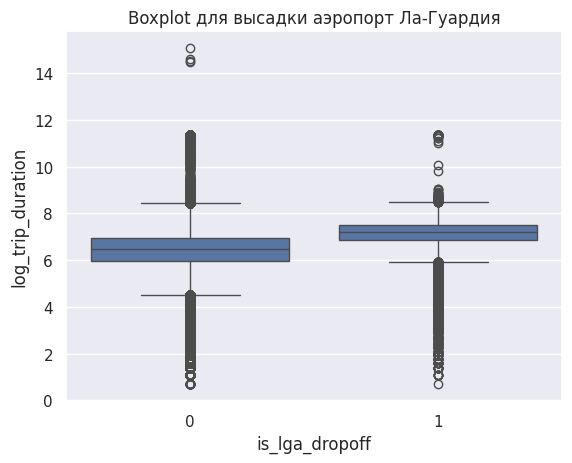

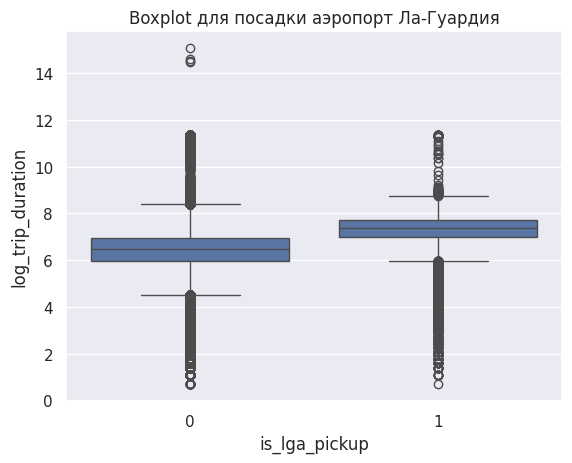

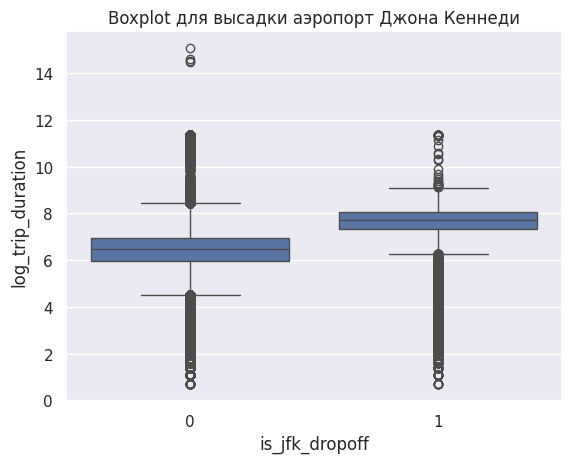

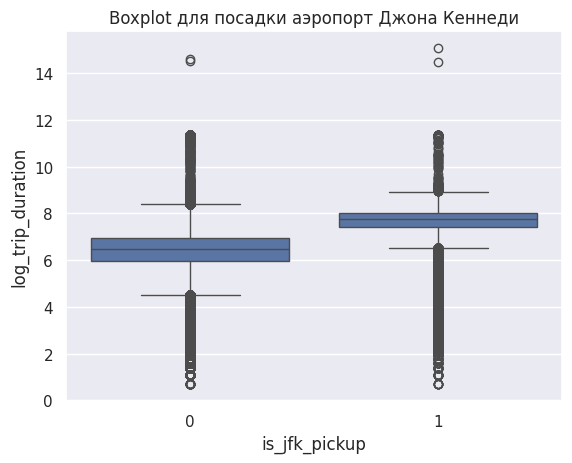

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
sns.boxplot(data=train, x='is_lga_dropoff', y='log_trip_duration')
plt.title('Boxplot для высадки аэропорт Ла-Гуардия')
plt.show()
sns.boxplot(data=train, x='is_lga_pickup', y='log_trip_duration')
plt.title('Boxplot для посадки аэропорт Ла-Гуардия')
plt.show()
sns.boxplot(data=train, x='is_jfk_dropoff', y='log_trip_duration')
plt.title('Boxplot для высадки аэропорт Джона Кеннеди')
plt.show()
sns.boxplot(data=train, x='is_jfk_pickup', y='log_trip_duration')
plt.title('Boxplot для посадки аэропорт Джона Кеннеди')
plt.show()

Получилось слишком много выбросов, так как некоторым близко ехать до аэропорта (из Бруклина, например), а некоторым далеко и по пробкам. Также может быть некоторые на метро/общественном транспорте доезжают до ближайшего пункта и затем вызывают такси. </br>
Хотя с другой стороны и среднее, и разброс между посадкой/высадкой из аэропорта и обратной ситуацией довольно различимы.

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

**Задание 9 (0.5 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на всех признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [ ]:
tab_ohe = train[train.columns[-6:]]
tab_ohe.head()

log_haversine  traffic_jam  is_jfk_pickup  is_lga_pickup  is_jfk_dropoff  \
0       0.915699            1              0              0               0   
1       1.031584            0              0              0               0   
2       1.999464            1              0              0               0   
3       0.910473            1              0              0               0   
4       0.783257            0              0              0               0   

   is_lga_dropoff  
0               0  
1               0  
2               0  
3               0  
4               0

In [ ]:
X_train_ohe, X_test_ohe, y_train, y_test  = train_test_split(tab_ohe, target, \
                                                     test_size=0.3,\
                                                     shuffle=True,
                                                     random_state=0)

In [ ]:
scaler = StandardScaler()
X_train_ohe['log_haversine'] = scaler.fit_transform(X_train_ohe[['log_haversine']])
X_test_ohe['log_haversine'] = scaler.transform(X_test_ohe[['log_haversine']])

In [ ]:
clf = Ridge()
clf.fit(X_train_ohe, y_train)

y_pred = clf.predict(X_test_ohe)

In [ ]:
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'R²: {r2_score(y_test, y_pred)}')

MSE: 0.24791285835834379
R²: 0.6062676851870903


╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ</br>
MSE уменьшилось почти в 2,5 раза. Коэффициент детерминации также увеличился почти в 3 раза. Точность модели повысилась

## Часть 3. Изучаем оставшиеся признаки (1.5 балл)

**Задание 10 (1 балл)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
display('Уникальные вендоры', train['vendor_id'].value_counts())
display('Уникальное число пассажиров', train['passenger_count'].value_counts())
display('Уникальные флаги', train['store_and_fwd_flag'].value_counts())

'Уникальные вендоры'

vendor_id
2    780302
1    678342
Name: count, dtype: int64

'Уникальное число пассажиров'

passenger_count
1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: count, dtype: int64

'Уникальные флаги'

store_and_fwd_flag
N    1450599
Y       8045
Name: count, dtype: int64

Про потенциальную оценку - тяжело, конечно) </br>
Уникальность вендора кажется не очень "стоящей" информацией.</br>
Кол-во пассажиров: потенциально, чем больше пассажиров, тем дальше поездка (типа на пикник, загород)</br>
Флаг, хранилась ли информация в таксометре: как будто также флажок Y может указывать, что связь потерялась где-то загородом, на шоссе, т.е. продолжительность поездки дольше. Но связь также могла потеряться и в туннелях, например.

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

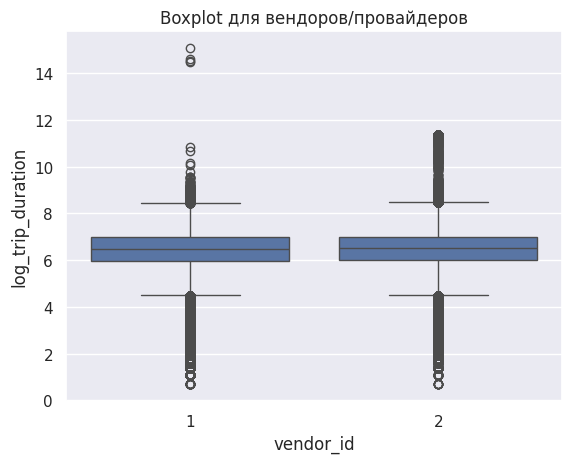

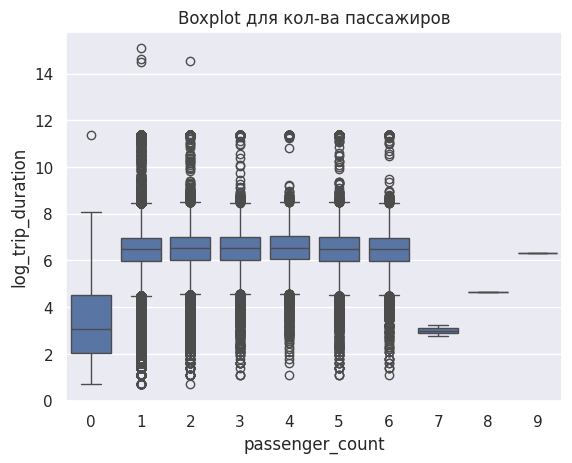

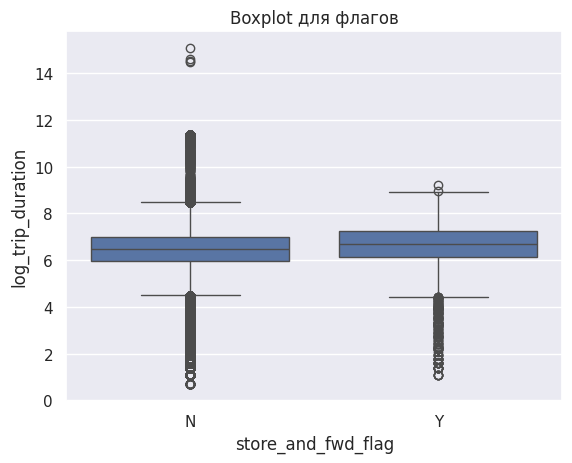

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
sns.boxplot(data=train, x='vendor_id', y='log_trip_duration')
plt.title('Boxplot для вендоров/провайдеров')
plt.show()
sns.boxplot(data=train, x='passenger_count', y='log_trip_duration')
plt.title('Boxplot для кол-ва пассажиров')
plt.show()
sns.boxplot(data=train, x='store_and_fwd_flag', y='log_trip_duration')
plt.title('Boxplot для флагов')
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train['vendor_id'] = np.where(train['vendor_id']==1, 0, 1)
train['store_and_fwd_flag'] =  np.where(train['store_and_fwd_flag']=='Y', 1, 0)
train.head()

id  vendor_id     pickup_datetime  passenger_count  \
0  id2875421          1 2016-03-14 17:24:55                1   
1  id2377394          0 2016-06-12 00:43:35                1   
2  id3858529          1 2016-01-19 11:35:24                1   
3  id3504673          1 2016-04-06 19:32:31                1   
4  id2181028          1 2016-03-26 13:30:55                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   
3        -74.010040        40.719971         -74.012268         40.706718   
4        -73.973053        40.793209         -73.972923         40.782520   

   store_and_fwd_flag  log_trip_duration  ...  day_hour    month  anomaly  \
0                   0           6.122493  ...        17    March        0   
1                   0           6.498282  ...         0     June        0   
2                   0           7.661527  ...        11  January        0   
3                   0           6.063785  ...        19    April        0   
4                   0           6.077642  ...        13    March        0   

  distance_haversine  log_haversine  traffic_jam  is_jfk_pickup  \
0           1.498521       0.915699            1              0   
1           1.805507       1.031584            0              0   
2           6.385098       1.999464            1              0   
3           1.485498       0.910473            1              0   
4           1.188588       0.783257            0              0   

   is_lga_pickup  is_jfk_dropoff  is_lga_dropoff  
0              0               0               0  
1              0               0               0  
2              0               0               0  
3              0               0               0  
4              0               0               0  

[5 rows x 22 columns]

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

Кажется, что нет, признаки не сильные в сравнении с предыдущими. Здесь границы среднего и разброса между классами менее четкие (кроме некоторых классов кол-ва пассажиров). По провайдерам "ящики" очень похожи, по флагам, конечно, там где не писались поездки более длительные.

**Задание 11 (0.5 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [ ]:
tab_ohe = train[['vendor_id', 'passenger_count', 'store_and_fwd_flag']] # масштабировать кол-во пассажиров я не стала,
# это как будто не имеет смысла, так как уже этот столбец, как будто, разделен на классы
# кстати, попробовала и с масштабированными, результат один и тот же
tab_ohe.head()

vendor_id  passenger_count  store_and_fwd_flag
0          1                1                   0
1          0                1                   0
2          1                1                   0
3          1                1                   0
4          1                1                   0

In [ ]:
X_train_ohe, X_test_ohe, y_train, y_test  = train_test_split(tab_ohe, target, \
                                                     test_size=0.3,\
                                                     shuffle=True,
                                                     random_state=0)

In [ ]:
clf = Ridge()
clf.fit(X_train_ohe, y_train)

y_pred = clf.predict(X_test_ohe)

In [ ]:
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'R²: {r2_score(y_test, y_pred)}')

MSE: 0.6291476361860966
R²: 0.0007950503456206626


#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ</br>
Точность стала намного хуже, чем с прошлыми признаками.

In [ ]:
train = train.drop(columns=['vendor_id', 'passenger_count', 'store_and_fwd_flag'])

Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 12 (1.5 балла)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии (что?). В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

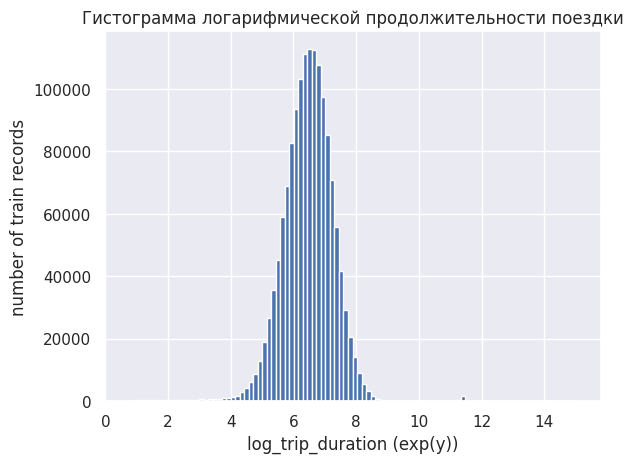

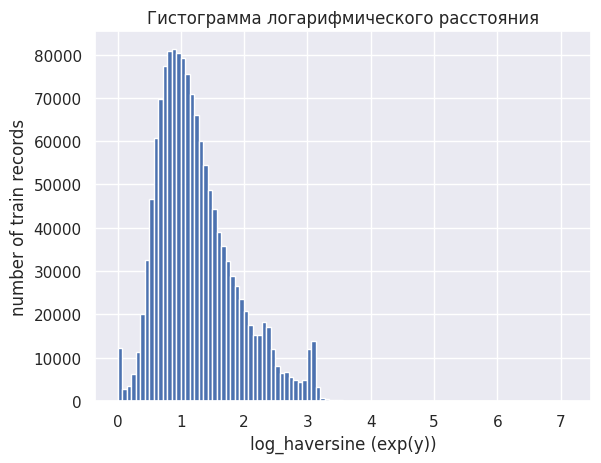

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plt.hist(train.log_trip_duration.values, bins=100)
plt.title('Гистограмма логарифмической продолжительности поездки')
plt.xlabel('log_trip_duration (exp(y))')
plt.ylabel('number of train records')
plt.show()

plt.hist(train.log_haversine.values, bins=100)
plt.title('Гистограмма логарифмического расстояния')
plt.xlabel('log_haversine (exp(y))')
plt.ylabel('number of train records')
plt.show()

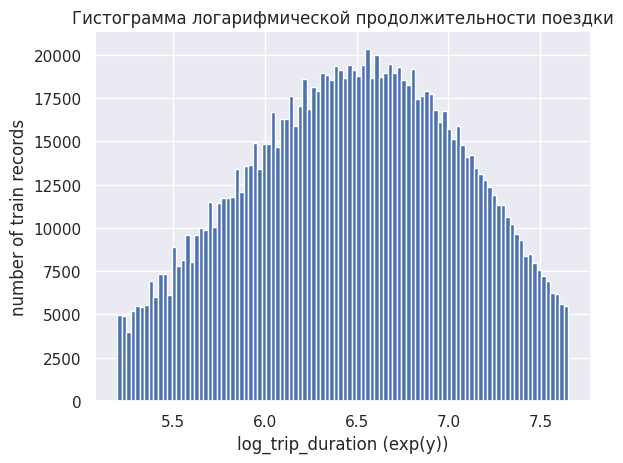

In [ ]:
quant_95_duration = train['log_trip_duration'].quantile(0.95)
quant_05_duration = train['log_trip_duration'].quantile(0.05)
train = train[(train['log_trip_duration'] <= quant_95_duration) & (train['log_trip_duration'] >= quant_05_duration)]
plt.hist(train.log_trip_duration.values, bins=100)
plt.title('Гистограмма логарифмической продолжительности поездки')
plt.xlabel('log_trip_duration (exp(y))')
plt.ylabel('number of train records')
plt.show()

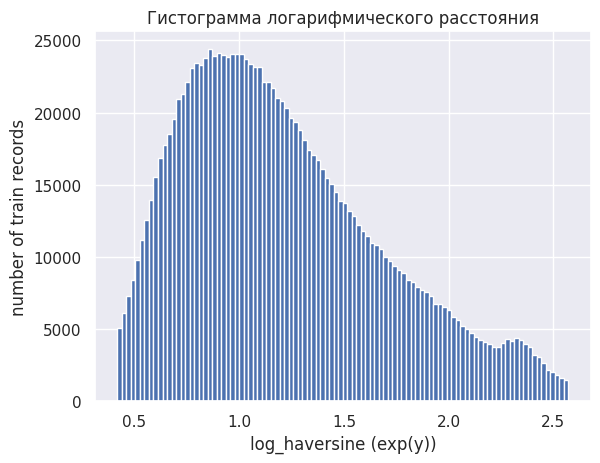

In [ ]:
quant_98_haversine = train['log_haversine'].quantile(0.98)
quant_02_haversine = train['log_haversine'].quantile(0.02)
train = train[(train['log_haversine'] <= quant_98_haversine) & (train['log_haversine'] >= quant_02_haversine)]
plt.hist(train.log_haversine.values, bins=100)
plt.title('Гистограмма логарифмического расстояния')
plt.xlabel('log_haversine (exp(y))')
plt.ylabel('number of train records')
plt.show()


Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
#train['pickup_longitude'] = np.where(.value_counts()
# Маска для кол-ва значений одного и того же места меньше 5
# mask = train['pickup_longitude'].isin(train['pickup_longitude'].value_counts()[train['pickup_longitude'].value_counts() < 5].index)

# rare_values = train.loc[mask, 'pickup_longitude'].unique()
# # Находим для них среднее значение
# mean_value = train.loc[train['pickup_longitude'].isin(rare_values), 'pickup_longitude'].mean()

# # Заменим редкие значения на среднее
# train.loc[train['pickup_longitude'].isin(rare_values), 'pickup_longitude'] = mean_value

Сначала думала сделать так, как написала выше для каждой широты и долготы. Но потом мне показалось это не совсем честным, ведь может точка +- частая, просто поставили рядом, чтобы немного пройтись. Да и усреднение вообще дает результаты +-трамвайная остановка... </br>
Думала, что кол-во пассажиров 6-7-8 можно объединить в один класс, но этот столбец выкинули из-за малой информативности.

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

**Задание 13 (1.5 балла)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
tab_ohe = pd.get_dummies(train, columns=['week_day', 'day_hour', 'month', 'day_of_year'], drop_first=True)
print('Разница между кол-вом столбцов до OHE и после: ', len(tab_ohe.columns)-len(train.columns))

Разница между кол-вом столбцов до OHE и после:  211


In [ ]:
target = tab_ohe.log_trip_duration
tab_ohe = tab_ohe.drop(columns=['id', 'pickup_datetime', 'log_trip_duration', 'distance_haversine'])

In [ ]:
tab_ohe.columns[:15]

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'anomaly', 'log_haversine', 'traffic_jam',
       'is_jfk_pickup', 'is_lga_pickup', 'is_jfk_dropoff', 'is_lga_dropoff',
       'week_day_Monday', 'week_day_Saturday', 'week_day_Sunday',
       'week_day_Thursday'],
      dtype='object')

In [ ]:
X_train_ohe, X_test_ohe, y_train, y_test  = train_test_split(tab_ohe, target, \
                                                     test_size=0.3,\
                                                     shuffle=True,
                                                     random_state=0)

In [ ]:
scaler = StandardScaler()
X_train_ohe['log_haversine'] = scaler.fit_transform(X_train_ohe[['log_haversine']])
X_test_ohe['log_haversine'] = scaler.transform(X_test_ohe[['log_haversine']])

In [ ]:
clf = Ridge()
clf.fit(X_train_ohe, y_train)

y_pred = clf.predict(X_test_ohe)

In [ ]:
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'R²: {r2_score(y_test, y_pred)}')

MSE: 0.12546560860609055
R²: 0.6128049555858375


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
cll = Lasso()
cll.fit(X_train_ohe, y_train)

y_pred = cll.predict(X_test_ohe)

In [ ]:
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'R²: {r2_score(y_test, y_pred)}')

MSE: 0.324037506544703
R²: -8.618484490519052e-07


Лучше оказалась Ridge

Разбейте _обучающую выборку_ на 5 фолдов кросс-валидации. Подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
parameters = {'alpha' : np.logspace(-5, 0, 5)}

cv = GridSearchCV(Lasso(), parameters, cv=5)

cv.fit(X_train_ohe, y_train)


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-05, 1.77827941e-04, 3.16227766e-03, 5.62341325e-02,
       1.00000000e+00])})

In [ ]:
cr = GridSearchCV(Ridge(), parameters, cv=5)
cr.fit(X_train_ohe, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-05, 1.77827941e-04, 3.16227766e-03, 5.62341325e-02,
       1.00000000e+00])})

In [ ]:
best_lasso = cv.best_estimator_
best_ridge = cr.best_estimator_

y_pred_lasso = best_lasso.predict(X_test_ohe)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f"Lasso MSE: {mse_lasso}, Best alpha: {cv.best_params_}")

y_pred_ridge = best_ridge.predict(X_test_ohe)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f"Ridge MSE: {mse_ridge}, Best alpha: {cr.best_params_}")

Lasso MSE: 0.12546840410492924, Best alpha: {'alpha': np.float64(1e-05)}
Ridge MSE: 0.12546587405844176, Best alpha: {'alpha': np.float64(0.05623413251903491)}


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
coefs = {}
inter = {}
for param in parameters['alpha']:
    model = Lasso(alpha=param).fit(X_train_ohe, y_train)
    coefs[param] = model.coef_
    inter[param]= model.intercept_



In [ ]:
all_coefs = {alpha: np.concatenate((np.atleast_1d(coefs[alpha]), np.atleast_1d(inter[alpha]))) for alpha in parameters['alpha']}

threshold = 1e-6 # вставила порог, потому что иначе 0.00000+e0 не учитывалось, как == 0

zero_coeffs = {alpha: np.sum(np.abs(coef) <= threshold) for alpha, coef in all_coefs.items()}

In [ ]:
for alpha, count in zero_coeffs.items():
    print(f"Alpha={alpha:.5f}: {count} нулевых коэффициентов")

Alpha=0.00001: 21 нулевых коэффициентов
Alpha=0.00018: 141 нулевых коэффициентов
Alpha=0.00316: 214 нулевых коэффициентов
Alpha=0.05623: 224 нулевых коэффициентов
Alpha=1.00000: 226 нулевых коэффициентов


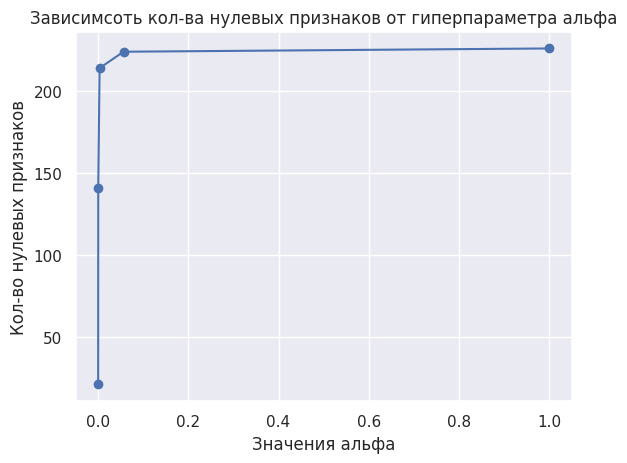

In [ ]:
plt.plot(parameters['alpha'], list(zero_coeffs.values()), 'o-')
plt.title('Зависимсоть кол-ва нулевых признаков от гиперпараметра альфа')
plt.xlabel('Значения альфа')
plt.ylabel('Кол-во нулевых признаков')
plt.show()

Соответственно, чем больше альфа, тем больше нулевых признаков.

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

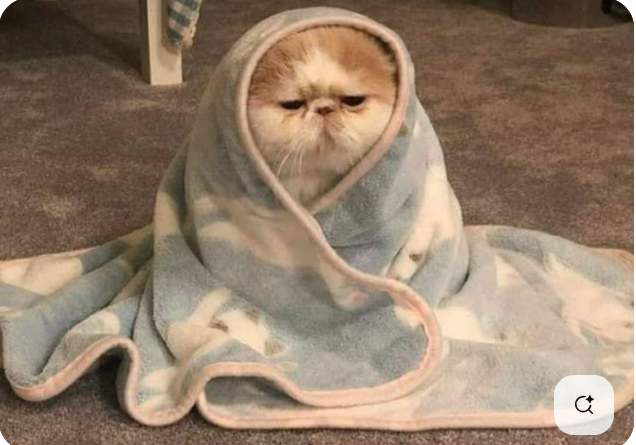

Это дз понравилось больше, чем первое, тут были понятнее условия и выполнение. Но возникли большие проблемы с Лассо, что считалось почти 20 минут при кросс-валидации, что больно...